In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model, Model
from keras.applications.xception import Xception
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dropout, Dense, Embedding, LSTM, Concatenate, Activation, Dot, Reshape, Lambda, Add, Flatten, RepeatVector
from keras.utils import to_categorical, plot_model
from keras.preprocessing.text import Tokenizer
from pickle import load, dump
from tqdm import tqdm
import os
import string
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import keras.backend as K
import random
from nltk.translate.bleu_score import corpus_bleu

# Initializing tqdm for progress bars
tqdm.pandas()

# Check for GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

# Setting device to GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)


Num GPUs Available:  1
Default GPU Device: /device:GPU:0


In [2]:
# Loading and cleaning of descriptions
def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

# Parsing the above for image-caption mappings
def load_image_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    image_captions = {}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in image_captions:
            image_captions[img[:-2]] = [caption]
        else:
            image_captions[img[:-2]].append(caption)
    return image_captions

# Cleaning of captions
def clean_captions(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption = img_caption.replace("-", " ")
            words = img_caption.split()
            words = [word.lower() for word in words]
            words = [word.translate(table) for word in words]
            words = [word for word in words if len(word) > 1]
            words = [word for word in words if word.isalpha()]
            img_caption = ' '.join(words)
            captions[img][i] = img_caption
    return captions

# Building a new vocabulary from the cleaned captions
def build_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

# Converting dictionary to list of descriptions
def convert_dict_to_list(descriptions):
    all_descriptions = []
    for key in descriptions.keys():
        [all_descriptions.append(d) for d in descriptions[key]]
    return all_descriptions

# Creating a tokenizer from the list of descriptions
def create_tokenizer(descriptions):
    description_list = convert_dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(description_list)
    return tokenizer

# Calculation of max length
def get_max_caption_length(descriptions):
    description_list = convert_dict_to_list(descriptions)
    return max(len(d.split()) for d in description_list)


dataset_text = "/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flickr8k_text"
dataset_images = "/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flicker8k_Dataset"

print("Loading and cleaning descriptions...")

# Loading, cleaning, and preparing of descriptions
caption_file = os.path.join(dataset_text, "Flickr8k.token.txt")
image_captions = load_image_captions(caption_file)
cleaned_captions = clean_captions(image_captions)
vocabulary = build_vocabulary(cleaned_captions)

# Creating and saving the tokenizer
tokenizer = create_tokenizer(cleaned_captions)
dump(tokenizer, open('tokenizer.p', 'wb'))

# Calculation of vocabulary size and maximum length
vocabulary_size = len(tokenizer.word_index) + 1
max_caption_length = get_max_caption_length(cleaned_captions)

print(f"Vocabulary Size: {vocabulary_size}")
print(f"Max Caption Length: {max_caption_length}")


Loading and cleaning descriptions...
Vocabulary Size: 8423
Max Caption Length: 33


In [ ]:
# VGG16 model for feature extraction
vgg16_model = VGG16(include_top=False, pooling='avg')

# Extracting features from images
def extract_image_features(image_directory, model):
    image_features = {}
    for image_filename in os.listdir(image_directory):
        image_path = os.path.join(image_directory, image_filename)
        try:
            image = load_img(image_path, target_size=(224, 224))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            image_features[image_filename] = feature
        except Exception as e:
            print(f"Error processing {image_filename}: {e}")
    return image_features


features = "/content/drive/MyDrive/Spring 24/PTR/Project/features_vgg16.pkl"

# Extracting features and dumping to pickle file
image_features = extract_image_features(dataset_images, vgg16_model)
with open(features, 'wb') as file:
    dump(image_features, file)


In [3]:
features = "/content/drive/MyDrive/Spring 24/PTR/Project/features_vgg16.pkl"
train_images = os.path.join(dataset_text, "Flickr_8k.trainImages.txt")
test_images = os.path.join(dataset_text, "Flickr_8k.testImages.txt")
val_images = os.path.join(dataset_text, "Flickr_8k.devImages.txt")

# Load features from pickle file
def load_image_features(file_path):
    with open(file_path, 'rb') as file:
        image_features = pickle.load(file)
    return image_features

# Loading of image
def load_image_filenames(file_path):
    with open(file_path, 'r') as file:
        image_filenames = file.read().strip().split("\n")
    return image_filenames

# Loading image features
image_features = load_image_features(features)

# Load training, test, and validation images
train_imgs = load_image_filenames(train_images)
test_imgs = load_image_filenames(test_images)
val_imgs = load_image_filenames(val_images)

# Combining test and validation images into a single list
test_imgs.extend(val_imgs)

# Training descriptions and features
train_descriptions = {img: cleaned_captions[img] for img in train_imgs if img in cleaned_captions}
train_features = {img: image_features[img] for img in train_imgs if img in image_features}

# Printng of above mentioned parameters
print(f"Number of training images: {len(train_imgs)}")
print(f"Number of test images: {len(test_imgs)}")
print(f"Number of training descriptions: {len(train_descriptions)}")
print(f"Number of training features: {len(train_features)}")
print("Data loading and preprocessing complete.")

Number of training images: 6000
Number of test images: 2000
Number of training descriptions: 6000
Number of training features: 5997
Data loading and preprocessing complete.


In [4]:
def data_generator(descriptions, features, tokenizer, max_length, batch_size=32):
    while True:
        image_ids = list(descriptions.keys())
        np.random.shuffle(image_ids)
        for i in range(0, len(image_ids), batch_size):
            batch_image_ids = image_ids[i:i+batch_size]
            batch_features, batch_sequences, batch_labels = [], [], []
            for image_id in batch_image_ids:
                if image_id in features:
                    feature = features[image_id].flatten()
                    for desc in descriptions[image_id]:
                        seq = tokenizer.texts_to_sequences([desc])[0]
                        for j in range(1, len(seq)):
                            in_seq, out_seq = pad_sequences([seq[:j]], maxlen=max_length)[0], to_categorical([seq[j]], num_classes=vocabulary_size)[0]
                            batch_features.append(feature)
                            batch_sequences.append(in_seq)
                            batch_labels.append(out_seq)
            yield [[np.array(batch_features), np.array(batch_sequences)], np.array(batch_labels)]


In [5]:
def define_model(vocabulary_size, max_caption_length):

    image_input = Input(shape=(512,))
    fe1 = Dropout(0.5)(image_input)
    fe2 = Dense(256, activation='relu')(fe1)

    # Textual input
    sequence_input = Input(shape=(max_caption_length,))
    se1 = Embedding(vocabulary_size, 256, mask_zero=True)(sequence_input)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Decoder
    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocabulary_size, activation='softmax')(decoder2)

    model = Model(inputs=[image_input, sequence_input], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    return model


Dataset:  6000
Descriptions: train= 6000
Photos: train= 5997
Vocabulary Size: 8423
Description Length: 33
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 33)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 33, 256)              2156288   ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 512)                  0         ['input_1[0][0]']  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/187 [==============================] - 42s 225ms/step - loss: 4.8925
Epoch 2: Cross-Entropy Loss = 4.89248514175415
187/187 [==============================] - 41s 218ms/step - loss: 4.2546
Epoch 3: Cross-Entropy Loss = 4.254636287689209
187/187 [==============================] - 41s 221ms/step - loss: 3.9300
Epoch 4: Cross-Entropy Loss = 3.9299631118774414
187/187 [==============================] - 41s 218ms/step - loss: 3.6995
Epoch 5: Cross-Entropy Loss = 3.699453592300415
187/187 [==============================] - 41s 218ms/step - loss: 3.5177
Epoch 6: Cross-Entropy Loss = 3.5177042484283447
187/187 [==============================] - 42s 223ms/step - loss: 3.3672
Epoch 7: Cross-Entropy Loss = 3.367157459259033
187/187 [==============================] - 41s 219ms/step - loss: 3.2378
Epoch 8: Cross-Entropy Loss = 3.2378039360046387
187/187 [==============================] - 43s 230ms/step - loss: 3.1289
Epoch 9: Cross-Entropy Loss = 3.128929376602173
187/187 [=====================

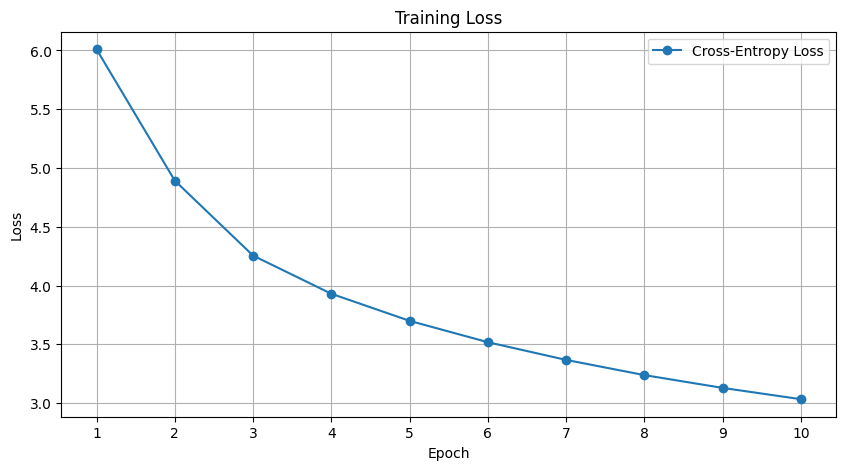

In [14]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocabulary_size)
print('Description Length:', max_caption_length)

model = define_model(vocabulary_size, max_caption_length)
epochs = 10
batch_size = 32
steps = len(train_descriptions) // batch_size

if not os.path.exists("models"):
    os.mkdir("models")

loss_history = []

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_caption_length, batch_size)
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(f"models/model_{i}.h5")
    current_loss = history.history['loss'][0]
    loss_history.append(current_loss)
    print(f"Epoch {i+1}: Cross-Entropy Loss = {current_loss}")

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Cross-Entropy Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(epochs), range(1, epochs + 1))
plt.legend()
plt.show()


In [7]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None or word == 'end':
            break
        in_text += ' ' + word
    return in_text.strip()

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = [], []
    for key, desc_list in tqdm(list(descriptions.items()), desc="Evaluating"):
        if key in photos:
            photo = photos[key]
            photo = photo.reshape((1, 512))
            yhat = generate_desc(model, tokenizer, photo, max_length)
            references = [d.split()[:10] for d in desc_list]
            actual.append(references)
            predicted.append(yhat.split()[:10])


    if not actual or not predicted:
        print("No actual or predicted values to compare for BLEU score calculation.")
        return 0, 0, 0, 0


    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print(f'BLEU-1: {bleu1:.4f}')
    print(f'BLEU-2: {bleu2:.4f}')
    print(f'BLEU-3: {bleu3:.4f}')
    print(f'BLEU-4: {bleu4:.4f}')
    return bleu1, bleu2, bleu3, bleu4

tokenizer = load(open('tokenizer.p', 'rb'))

latest_model_path = '/content/drive/MyDrive/Spring 24/PTR/Project/saved_models/model_9.h5'
model = load_model(latest_model_path)

test_descriptions = {img: cleaned_captions[img] for img in test_imgs if img in cleaned_captions}
test_features = {img: image_features[img] for img in test_imgs if img in image_features}

combined_descriptions = {**train_descriptions, **test_descriptions}
combined_features = {**train_features, **test_features}

filtered_keys = [k for k in combined_descriptions.keys() if k in combined_features]
print(f"Total number of images available: {len(filtered_keys)}")

num_samples = min(2000, len(filtered_keys))
print(f"Number of images selected for evaluation: {num_samples}")

selected_keys = random.sample(filtered_keys, num_samples)
selected_descriptions = {k: combined_descriptions[k] for k in selected_keys}
selected_features = {k: combined_features[k] for k in selected_keys}

print("Evaluating on Selected Data")
bleu1, bleu2, bleu3, bleu4 = evaluate_model(model, selected_descriptions, selected_features, tokenizer, max_caption_length)

print(f"BLEU-1 Score: {bleu1}")
print(f"BLEU-2 Score: {bleu2}")
print(f"BLEU-3 Score: {bleu3}")
print(f"BLEU-4 Score: {bleu4}")


Total number of images available: 7996
Number of images selected for evaluation: 2000
Evaluating on Selected Data


Evaluating: 100%|██████████| 2000/2000 [1:21:26<00:00,  2.44s/it]


BLEU-1: 0.4232
BLEU-2: 0.2502
BLEU-3: 0.1511
BLEU-4: 0.0871
BLEU-1 Score: 0.4232
BLEU-2 Score: 0.25022008090656694
BLEU-3 Score: 0.15112832950528365
BLEU-4 Score: 0.08708323704007623


In [9]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None or word == 'end':
            break
        in_text += ' ' + word
    return in_text.strip()

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = [], []
    for key, desc_list in tqdm(list(descriptions.items()), desc="Evaluating"):
        if key in photos:
            photo = photos[key]
            photo = photo.reshape((1, 512))
            yhat = generate_desc(model, tokenizer, photo, max_length)
            references = [d.split()[:10] for d in desc_list]
            actual.append(references)
            predicted.append(yhat.split()[:10])

    if not actual or not predicted:
        print("No actual or predicted values to compare for BLEU score calculation.")
        return 0, 0, 0, 0

    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print(f'BLEU-1: {bleu1:.4f}')
    print(f'BLEU-2: {bleu2:.4f}')
    print(f'BLEU-3: {bleu3:.4f}')
    print(f'BLEU-4: {bleu4:.4f}')
    return bleu1, bleu2, bleu3, bleu4

tokenizer = load(open('tokenizer.p', 'rb'))

latest_model_path = '/content/drive/MyDrive/Spring 24/PTR/Project/saved_models/model_9.h5'
model = load_model(latest_model_path)


test_descriptions = {img: cleaned_captions[img] for img in test_imgs if img in cleaned_captions}
test_features = {img: image_features[img] for img in test_imgs if img in image_features}


print("Evaluating on Test Data")
bleu1, bleu2, bleu3, bleu4 = evaluate_model(model, test_descriptions, test_features, tokenizer, max_caption_length)

print(f"BLEU-1 Score: {bleu1}")
print(f"BLEU-2 Score: {bleu2}")
print(f"BLEU-3 Score: {bleu3}")
print(f"BLEU-4 Score: {bleu4}")


Evaluating on Test Data


Evaluating: 100%|██████████| 2000/2000 [1:17:52<00:00,  2.34s/it]


BLEU-1: 0.3981
BLEU-2: 0.2225
BLEU-3: 0.1277
BLEU-4: 0.0695
BLEU-1 Score: 0.3981490745372686
BLEU-2 Score: 0.22254879371408015
BLEU-3 Score: 0.12765047412721145
BLEU-4 Score: 0.06949373856166904


Random Training Image Paths:
/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flicker8k_Dataset/3017220118_6a9212dfdb.jpg
/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flicker8k_Dataset/3580082200_ea10bf2f68.jpg
/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flicker8k_Dataset/1397295388_8a5b6b525d.jpg
/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flicker8k_Dataset/3535304540_0247e8cf8c.jpg
/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flicker8k_Dataset/3014015906_fdba461f36.jpg

Random Test Image Paths:
/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flicker8k_Dataset/3163198309_bbfe504f0a.jpg
/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flicker8k_Dataset/441398149_297146e38d.jpg
/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flicker8k_Dataset/1045521051_108ebc19be.jpg
/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flicker8k_Dataset/2083434441_a93bc6306b.jpg
/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flicker8k_Dataset/35

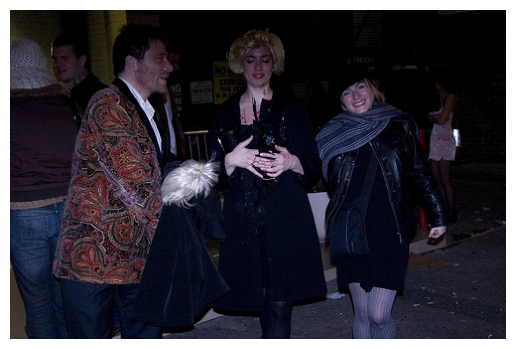


Generated Caption:

start of dog jumps over the grass to catch


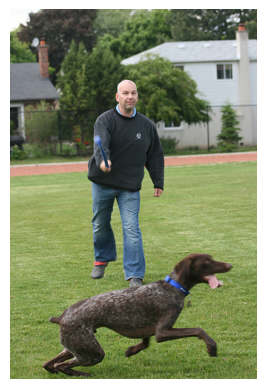


Generated Caption:

start of people in casino vegas odd are sitting


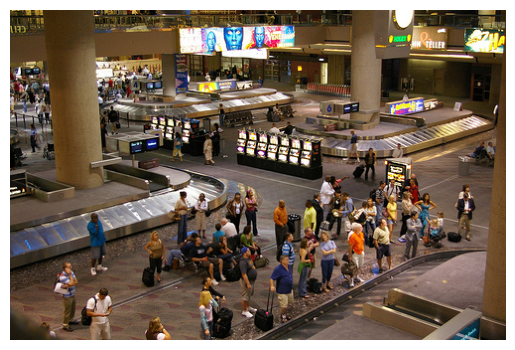


Generated Caption:

start of people are standing in the snow with


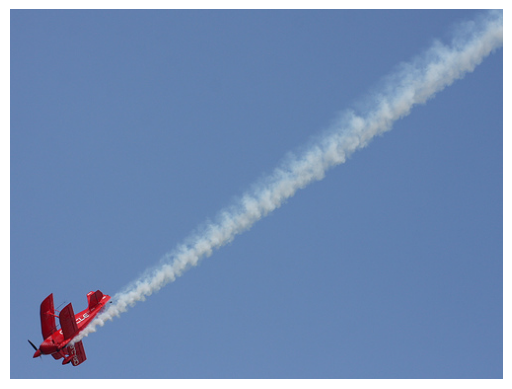


Generated Caption:

start of people in the woods and one person


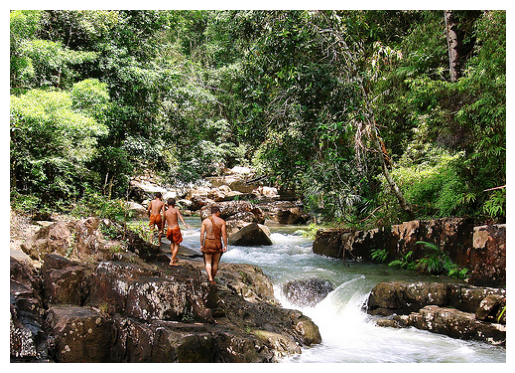


Captions for Random Test Images:

Generated Caption:

start of mountain of snow covered mountain in the


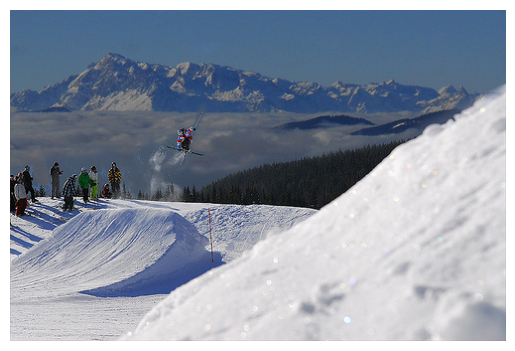


Generated Caption:

start of people stand in front of building and


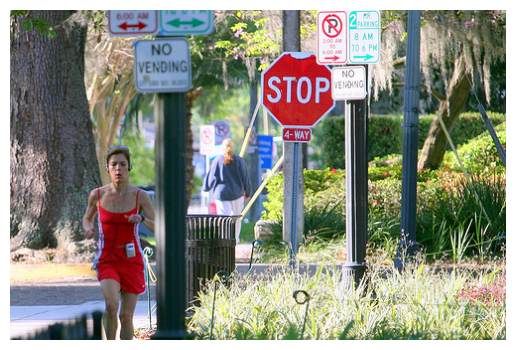


Generated Caption:

start of people are playing in the rain with


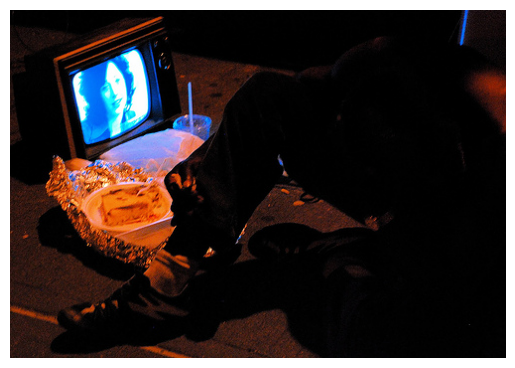


Generated Caption:

start of people in the snow and one man


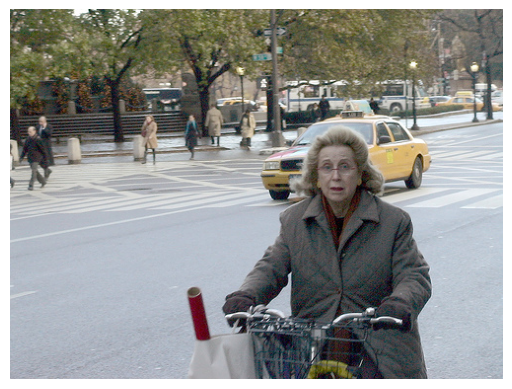


Generated Caption:

start of people are standing on the edge of


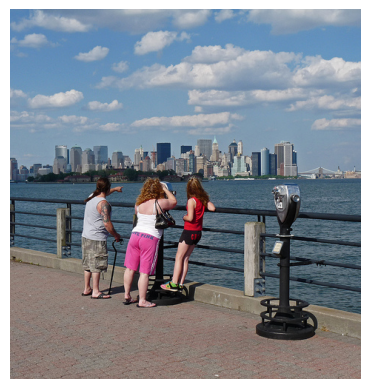

In [7]:
def get_random_images(image_list, image_dir, num_images=5):
    random_images = random.sample(image_list, num_images)
    image_paths = [os.path.join(image_dir, img) for img in random_images]
    return image_paths

train_image_dir = '/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flicker8k_Dataset'
test_image_dir = '/content/drive/MyDrive/Spring 24/PTR/Project/Dataset/Flicker8k_Dataset'

random_train_image_paths = get_random_images(train_imgs, train_image_dir, num_images=5)
random_test_image_paths = get_random_images(test_imgs, test_image_dir, num_images=5)

print("Random Training Image Paths:")
for path in random_train_image_paths:
    print(path)

print("\nRandom Test Image Paths:")
for path in random_test_image_paths:
    print(path)

expected_length = max_caption_length
actual_length = 8
tokenizer = load(open("tokenizer.p", "rb"))
model = load_model('/content/drive/MyDrive/Spring 24/PTR/Project/saved_models/model_9.h5')

features_path = '/content/drive/MyDrive/Spring 24/PTR/Project/features_vgg16.pkl'
with open(features_path, 'rb') as f:
    image_features = load(f)

def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except Exception as e:
        print(f"ERROR: Can't open image! Ensure that image path and extension is correct. {e}")
        return None
    image = image.resize((224, 224))
    image = np.array(image)
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo_features, expected_length, actual_length):
    in_text = 'start'
    for i in range(actual_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=expected_length)
        pred = model.predict([photo_features, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

def generate_captions_for_images(image_paths, model, tokenizer, expected_length, actual_length, features):
    for image_path in image_paths:
        feature_id = os.path.basename(image_path)
        if not os.path.isfile(image_path):
            print(f"ERROR: The file at {image_path} does not exist.")
            continue
        if feature_id not in features:
            print(f"ERROR: No features found for the image with ID {feature_id}.")
            continue

        photo_features = features[feature_id]
        photo_features = photo_features.reshape((1, 512))
        description = generate_desc(model, tokenizer, photo_features, expected_length, actual_length)
        img = Image.open(image_path)
        print("\nGenerated Caption:\n")
        print(description)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

print("\nCaptions for Random Training Images:")
generate_captions_for_images(random_train_image_paths, model, tokenizer, expected_length, actual_length, image_features)

print("\nCaptions for Random Test Images:")
generate_captions_for_images(random_test_image_paths, model, tokenizer, expected_length, actual_length, image_features)


In [15]:
import shutil
import os

source_dir = '/content/models'

destination_dir = '/content/drive/MyDrive/Spring 24/PTR/Project/saved_models'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

model_files = [f for f in os.listdir(source_dir) if f.endswith('.h5')]

for model_file in model_files:
    source_file = os.path.join(source_dir, model_file)
    destination_file = os.path.join(destination_dir, model_file)
    shutil.copy(source_file, destination_file)
    print(f'Copied {source_file} to {destination_file}')

print('All model files have been copied successfully.')


Copied /content/models/model_3.h5 to /content/drive/MyDrive/Spring 24/PTR/Project/saved_models/model_3.h5
Copied /content/models/model_7.h5 to /content/drive/MyDrive/Spring 24/PTR/Project/saved_models/model_7.h5
Copied /content/models/model_6.h5 to /content/drive/MyDrive/Spring 24/PTR/Project/saved_models/model_6.h5
Copied /content/models/model_0.h5 to /content/drive/MyDrive/Spring 24/PTR/Project/saved_models/model_0.h5
Copied /content/models/model_1.h5 to /content/drive/MyDrive/Spring 24/PTR/Project/saved_models/model_1.h5
Copied /content/models/model_8.h5 to /content/drive/MyDrive/Spring 24/PTR/Project/saved_models/model_8.h5
Copied /content/models/model_9.h5 to /content/drive/MyDrive/Spring 24/PTR/Project/saved_models/model_9.h5
Copied /content/models/model_5.h5 to /content/drive/MyDrive/Spring 24/PTR/Project/saved_models/model_5.h5
Copied /content/models/model_4.h5 to /content/drive/MyDrive/Spring 24/PTR/Project/saved_models/model_4.h5
Copied /content/models/model_2.h5 to /content/